# Summarizing Messages

In [1]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage
from typing import Literal

### Define the State

In [2]:
class State(MessagesState):
    summary: str

In [3]:
test_state = State()

In [4]:
test_state["summary"]

KeyError: 'summary'

In [5]:
bool(test_state.get("summary", ""))

False

### Define the Nodes

In [6]:
import os
os.environ.setdefault("no_proxy", "127.0.0.1,localhost")
os.environ.setdefault("HTTPX_NO_PROXY", "127.0.0.1,localhost")
OLLAMA_URL = os.getenv("OLLAMA_URL", "http://127.0.0.1:11434")

model_name = "gemma3" #"llama3.2:3b"

max_tokens = 100
llm = ChatOllama(model=model_name, num_predict=max_tokens, temperature=0)

In [7]:
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    
    question = "What is your question?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [8]:
def chatbot(state: State) -> State:

    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()

    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}

    Keep this in mind as you answer the next question.
    '''

    response = llm.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()

    return State(messages = [response])

In [9]:
def ask_another_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_another_question:")

    question = "Would you like to ask one more question (yes/no)?"
    print(question)

    return State(messages = [AIMessage(question), HumanMessage(input())])

In [10]:
def summarize_and_delete_messages(state: State) -> State:
    print(f"\n-------> ENTERING trim_messages:")

    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"

    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below.
Build upon the previous summary rather than repeating it so that the result
reflects the most recent context and developments.


Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''

    print(summary_instructions)

    summary = llm.invoke([HumanMessage(summary_instructions)])

    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]

    return State(messages = remove_messages, summary = summary.content)

### Define the Routing Function

In [11]:
def routing_function(state: State) -> Literal["summarize_and_delete_messages", "__end__"]:

    if state["messages"][-1].content == "yes":
        return "summarize_and_delete_messages"
    else:
        return "__end__"

### Define the Graph

In [12]:
graph = StateGraph(State)

In [13]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)
graph.add_node("summarize_and_delete_messages", summarize_and_delete_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)
graph.add_edge("summarize_and_delete_messages", "ask_question")

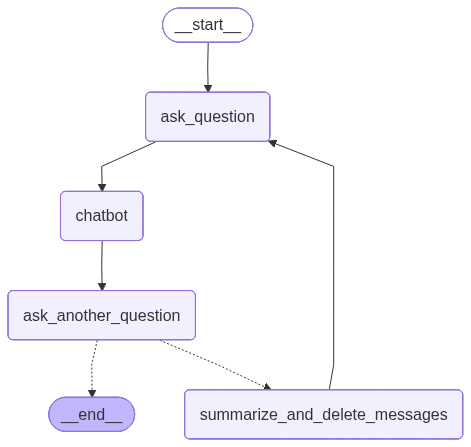

In [14]:
graph_compiled = graph.compile()
graph_compiled

### Test the Graph

In [15]:
graph_compiled.invoke(State(messages = []))


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

what's the capital of Iran?
================================== Ai Message ==================================

The capital of Iran is **Tehran**.

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?

-------> ENTERING trim_messages:

Update the ongoing summary by incorporating the new lines of conversation below.
Build upon the previous summary rather than repeating it so that the result
reflects the most recent context and developments.


Previous Summary:


New Conversation:
ai: What is your question?

human: what's the capital of Iran?

ai: The capital of Iran is **Tehran**.

ai: Would you like to ask one more question (yes/no)?

human: yes




-------> ENTERING ask_question:
What

{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='8e5de6f2-d931-479e-ac2b-345fcb57b7ea'),
  HumanMessage(content='how many population Mashhad has?', additional_kwargs={}, response_metadata={}, id='40bcf65f-f7dc-4981-89bf-89f3d5e470bf'),
  AIMessage(content='As of October 2023, Mashhad has an estimated population of approximately 1.6 million.', additional_kwargs={}, response_metadata={'model': 'gemma3', 'created_at': '2025-11-18T08:29:04.1484472Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5206062100, 'load_duration': 317335100, 'prompt_eval_count': 163, 'prompt_eval_duration': 2022586400, 'eval_count': 24, 'eval_duration': 2841007700, 'model_name': 'gemma3'}, id='run--fcbce259-7fff-4d58-88f3-6ebb8cb4d5ce-0', usage_metadata={'input_tokens': 163, 'output_tokens': 24, 'total_tokens': 187}),
  AIMessage(content='Would you like to ask one more question (yes/no)?', additional_kwargs={}, response_metadata={}, id='a8226a12-f4